In [1]:
import torch
from unet_repo import UNet
import rasterio
from matplotlib import pyplot as plt
import numpy as np
from treeseg_dataset import TreeDataset
from PIL import Image

In [4]:
model = UNet(2,1)
model.load_state_dict(torch.load("/home/winter/code/TreeSeg/checkpoints/epo100_onsample.pth"))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [8]:
print(next(model.parameters()).device)

cpu


In [15]:
def read_method(method:str=''):
    if method == 'Image' or method == '':
        return Image.open
    if method == 'rasterio':
        return rasterio.open
    if method == 'numpy':
        return np.load

min max of pan: -1.1880093812942505,4.426804542541504
min max of ndvi: -2.1380069255828857,2.8028767108917236
shape of pan: torch.Size([1, 256, 256])
min max of pred output: -951.382568359375,727.9051513671875
min max of pred probs: 0.0,1.0


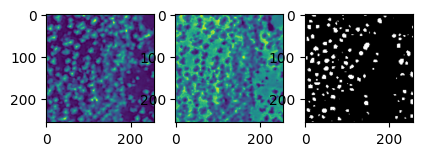

In [16]:
from os.path import join as pjoin
# dataset_dir = "/home/lenovo/treeseg-dataset/inference_train_data/inference_sample_128"
infer_data_root="/home/winter/code-resource/treeseg/inferdata/sample_128_onsample/"
# name_pat = '{}-0-area{}-r{}c{}.png'
name_pat = 'r{}c{}-{}-0.png'
# a = 137
r = 200
c = 100

pan = read_method('Image')(pjoin(infer_data_root, name_pat.format(r,c,'pan')))
ndvi = read_method('Image')(pjoin(infer_data_root, name_pat.format(r,c,'ndvi')))
# mask = read_method('Image')(pjoin(dataset_dir, name_pat.format(r,c,'annotation')))
pan = TreeDataset.preprocess(pan, (256,256), False, False)
ndvi = TreeDataset.preprocess(ndvi, (256,256), False, False)
# mask = TreeDataset.preprocess(mask, (256,256), True, False)
pan = torch.as_tensor(pan.copy())
ndvi = torch.as_tensor(ndvi.copy())
# mask = torch.as_tensor(mask.copy())

print(f'min max of pan: {torch.min(pan)},{torch.max(pan)}')
print(f'min max of ndvi: {torch.min(ndvi)},{torch.max(ndvi)}')
print(f'shape of pan: {pan.shape}')

input_img = torch.concat((pan,ndvi), dim=0)
input_img = torch.unsqueeze(input_img, 0)

pred_output = model(input_img)
print(f'min max of pred output: {torch.min(pred_output)},{torch.max(pred_output)}')

pred_probs = torch.sigmoid(pred_output)
print(f'min max of pred probs: {torch.min(pred_probs)},{torch.max(pred_probs)}')

pred_mask = pred_probs
pred_mask[pred_mask>=0.5] = 1
pred_mask[pred_mask<0.5] = 0

pred_mask = torch.squeeze(pred_mask)
segmap = Image.fromarray((pred_mask.detach().numpy()*255).astype(np.int8))

fig = plt.figure()

fig.add_subplot(1,4,1)
plt.imshow(pan.squeeze())
fig.add_subplot(1,4,2)
plt.imshow(ndvi.squeeze())
fig.add_subplot(1,4,3)
# plt.imshow(mask.squeeze())
# fig.add_subplot(1,4,4)
# plt.imshow(pred_mask.detach().squeeze())
plt.imshow(segmap)


In [17]:
result_dir = '/home/lenovo/treeseg-dataset/inference_train_data/merge_result_128_nonorm'
old_result_dir = '/home/lenovo/treeseg-dataset/inference_train_data/merge_result_128'
tif_dir = '/home/lenovo/treeseg-dataset/inference_train_data/tif'
data = read_method('rasterio')(f'{result_dir}/merge-result-segmap.png').read(1)
old_data = read_method('rasterio')(f'{old_result_dir}/merge-result-segmap.png').read(1)
pan = read_method('rasterio')(f'{tif_dir}/pan-0.tif').read(1)
ndvi = read_method('rasterio')(f'{tif_dir}/ndvi-0.tif').read(1)

RasterioIOError: /home/lenovo/treeseg-dataset/inference_train_data/merge_result_128_nonorm/merge-result-segmap.png: No such file or directory

In [ ]:
local = data[23600:25500,6900:8500]
old_local = old_data[23600:25500,6900:8500]
local_pan = pan[23600:25500,6900:8500]
local_ndvi = ndvi[23600:25500,6900:8500]

# 24064-24192, 7168:7296
ll1 = data[24064:24192, 7168:7296]
pan_ll1 = pan[24064:24192, 7168:7296]

fig2 = plt.figure(figsize=(15,30))
fig2.add_subplot(1,2,1)
plt.imshow(local)
fig2.add_subplot(1,2,2)
plt.imshow(old_local)
plt.show()

fig3 = plt.figure(figsize=(5,10))
fig3.add_subplot(1,2,1)
plt.imshow(ll1)
fig3.add_subplot(1,2,2)
plt.imshow(pan_ll1)
plt.show()

In [ ]:
l2 = local[500:800,500:600]
l2_old = old_local[500:800,500:600]
l2_pan = local_pan[500:800,500:600]

fig2 = plt.figure()

fig2.add_subplot(1,3,1)
plt.imshow(l2)
fig2.add_subplot(1,3,2)
plt.imshow(l2_old)
fig2.add_subplot(1,3,3)
plt.imshow(l2_pan)

plt.show()

In [ ]:
# inference local
# pan, ndvi, label, inference
tif_dir = '/home/lenovo/treeseg-dataset/inference_train_data/tif'
sample_dir = '/home/lenovo/treeseg-dataset/inference_train_data/inference_sample_128_nonorm'

r = 188
c = 56
pan_arr = np.asarray(read_method('Image')(f'{sample_dir}/r{r}c{c}-pan-0.png').resize((256,256)))
# pan_arr = np.zeros((256,256))
ndvi_arr = np.asarray(read_method('Image')(f'{sample_dir}/r{r}c{c}-ndvi-0.png').resize((256,256)))
# ndvi_arr = np.zeros((256,256))

pan_arr = pan[24064:24192, 7168:7296]
ndvi_arr = ndvi[24064:24192, 7168:7296]
pan_arr = np.asarray(Image.fromarray(pan_arr).resize((256,256)))
ndvi_arr = np.asarray(Image.fromarray(ndvi_arr).resize((256,256)))

print(f'mean: pan({np.mean(pan_arr)}), ndvi({np.mean(ndvi_arr)})')
print(f'var: pan({np.var(pan_arr)}), ndvi({np.var(ndvi_arr)})')

comb_img = np.transpose(np.stack((ndvi_arr, pan_arr),axis=0), axes=(1,2,0))
expand_img = comb_img[np.newaxis, :]
prediction = model.predict(expand_img, steps=1)
thr = 0.5
prediction[prediction>thr]=1
prediction[prediction<=thr]=0
prediction = np.squeeze(prediction)
# seg_map = Image.fromarray((prediction*255).astype(np.uint8))
# seg_map.show()

fig = plt.figure()

fig.add_subplot(1,3,1)
plt.imshow(pan_arr)
fig.add_subplot(1,3,2)
plt.imshow(ndvi_arr)
fig.add_subplot(1,3,3)
plt.imshow(prediction, cmap='binary')

plt.show()


[  0. 255.]


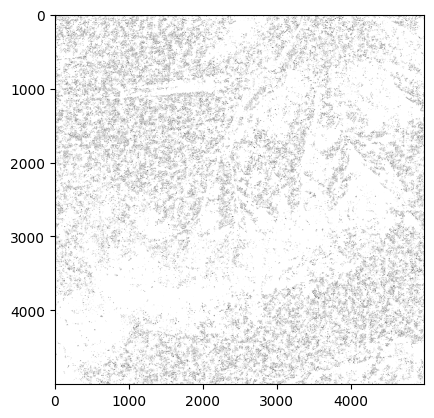

In [12]:
from matplotlib import pyplot as plt
from rasterio import open as rstopen
import numpy as np
merge_dir = "/home/winter/code-resource/treeseg/inferdata/result/merge_128_onsample/"

segmap = rstopen(f'{merge_dir}/merge-segmap-0.tif').read(1)
segmap = segmap[20000:25000, 10000:15000]
print(np.unique(segmap))
plt.imshow(segmap,cmap='binary')
plt.show()


In [ ]:
# TODO
# 1. no-norm split & train
# 2. sample clean 